# Exploración de datos

Vamos a analizar el dataset sucio para identificar problemas en los datos. Para ello, realizaremos los siguientes pasos en **ambos datasets (`train` y `test`)** de manera conjunta:

1. Mostramos un fragmento aleatorio del dataset (7 filas) para observar su estructura.
2. Verificamos los valores mínimos y máximos en cada columna para detectar posibles valores fuera de rango.
3. Buscamos valores faltantes en todas las características.
4. Identificamos filas duplicadas en el dataset.

In [53]:
import pandas as pd
import sys
sys.path.append("..\src")
from utils import data_info
df_dev = pd.read_csv("../data/raw/casas_dev.csv")
df_test = pd.read_csv("../data/raw/casas_test.csv")
data_info(df_dev, df_test)

Fragmento aleatorio
        area area_units  is_house  has_pool   age  price        lat        lon  \
290    99.0         m2         1         0  10.0  187.0 -34.650410 -58.427265   
363    67.0         m2         1         1  14.0  137.0 -34.601031 -58.360821   
393   164.0         m2         1         0  16.0  288.0 -34.645150 -58.352846   
79     67.0         m2         0         0   NaN  116.0 -34.655080 -58.341372   
284    45.0         m2         1         0  10.0   79.0 -34.589044 -58.353283   
376  1335.0       sqft         0         0   4.0  978.0  40.718857 -74.019304   
658    98.0         m2         1         1   7.0  207.0 -34.641880 -58.452644   

     rooms  
290    3.0  
363    2.0  
393    5.0  
79     2.0  
284    1.0  
376    4.0  
658    3.0  

Rango de valores de cada columna
        area  is_house  has_pool   age   price        lat        lon  rooms
min    40.0       0.0       0.0   1.0    65.0 -34.686302 -74.058238    1.0
max  2164.0       1.0       1.0  20.0  19

Del análisis previo, detectamos que la variable `area` tiene unidades inconsistentes. Primero, unificamos las unidades de la variable `area`, convirtiendo los valores expresados en **sqft** a **m²**. Luego, eliminamos la columna `area_units`, ya que no aporta información relevante.

Además, observamos que las propiedades están ubicadas en dos zonas bien diferenciadas según las coordenadas `lat` y `lon`. Para simplificar esta información, transformaremos estas dos variables en una única categoría que represente la zona. Dado que la representación categórica puede ser problemática para modelos numéricos, codificaremos esta nueva variable de forma binaria, asignando 0 a una zona y 1 a la otra.

También identificamos valores faltantes en las siguientes variables:  

- `age`, con **146 valores faltantes**.  
- `rooms`, con **76 valores faltantes**.  

En lugar de imputarlos directamente, primero analizaremos la relación entre las variables mediante un **pairplot**, un **boxplot** y un **countplot** comparativo. Esto nos permitirá visualizar posibles patrones en los valores faltantes y definir la mejor estrategia para completarlos.  

Además, exploraremos cómo varían ciertas características según la **zona**, lo que nos ayudará a entender si algunas propiedades son más comunes en determinadas áreas y cómo esto influye en la imputación.

No se encontraron valores fuera de rango ni filas duplicadas en el dataset.  

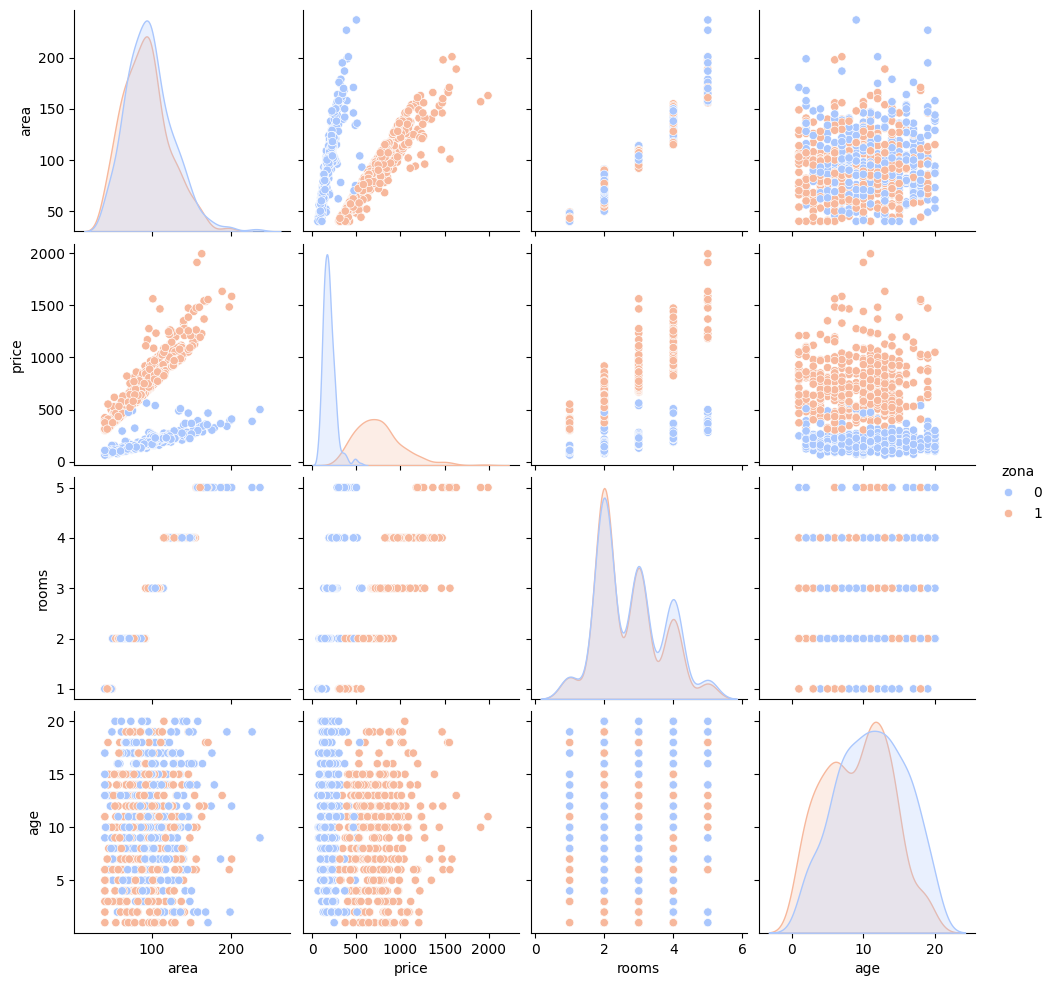

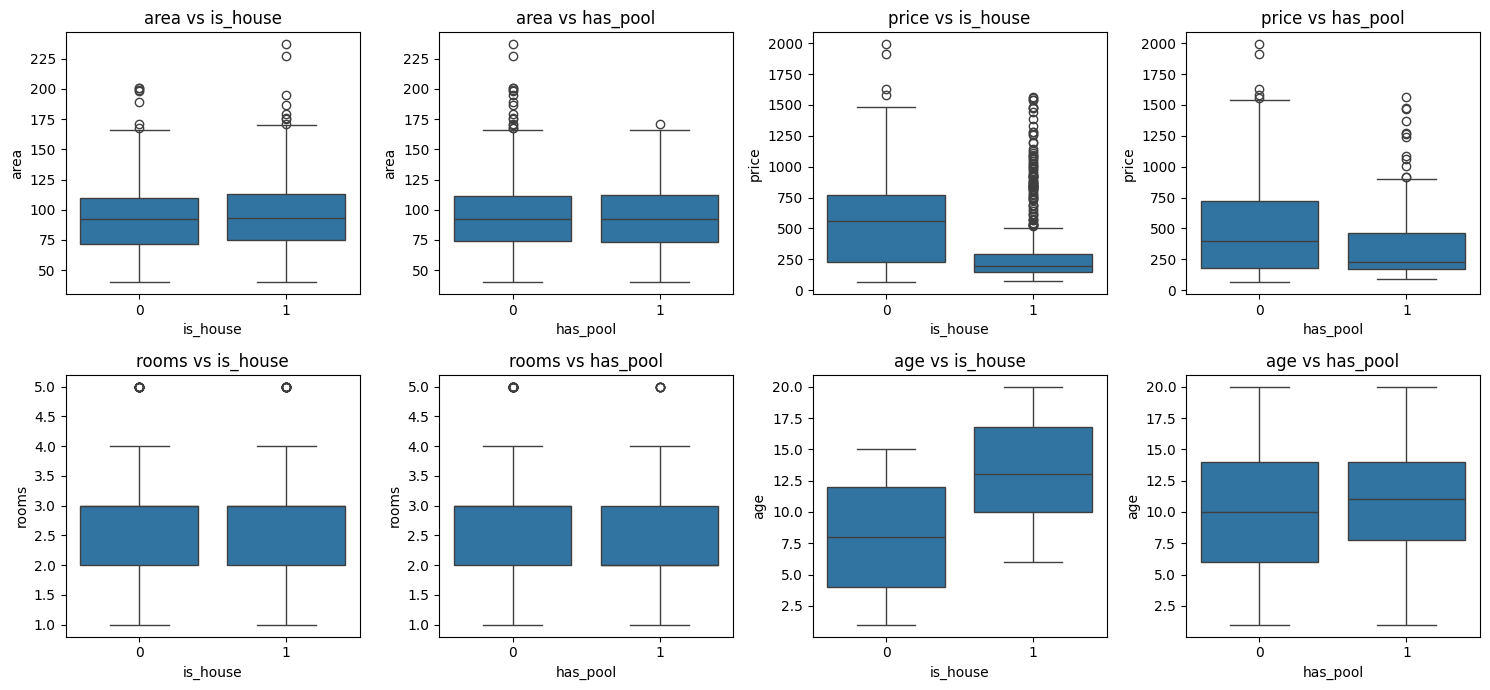

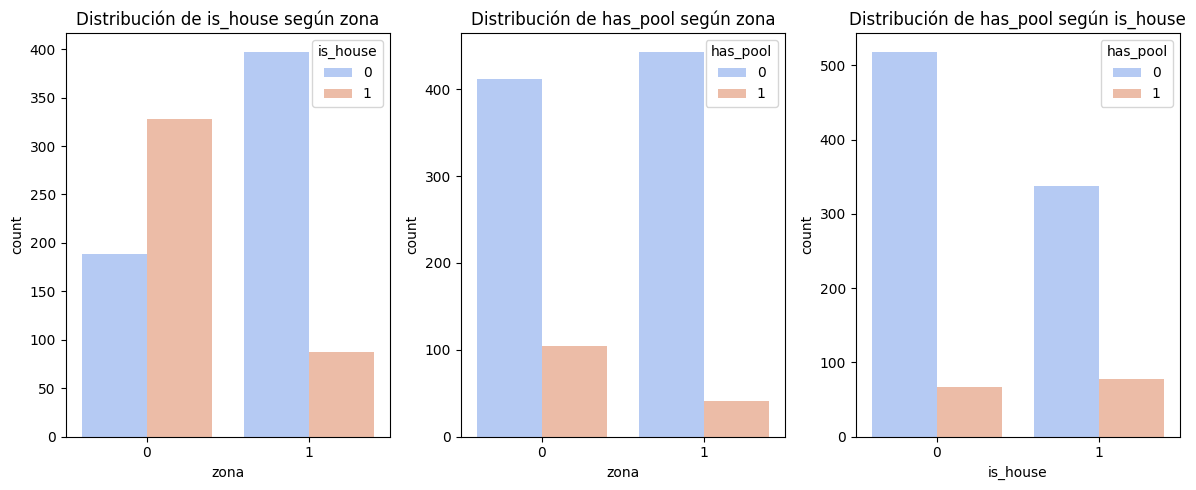

In [54]:
from preprocessing import convert_areaunits, one_hot_encoder
from utils import data_analisis

convert_areaunits(df_dev)
convert_areaunits(df_test)
one_hot_encoder(df_dev)
one_hot_encoder(df_test)
data_analisis(df_dev, df_test)


Al observar las relaciones, podemos definir estrategias para rellenar valores faltantes:  

- **NaNs en `rooms`**: Existe un patrón claro entre `rooms` y `area`, donde cada rango de área tiende a corresponder con un número específico de habitaciones. Podemos imputar los valores de `rooms` en función del área.  
- **NaNs en `age`**: La variable `is_house` influye en `age`, ya que las casas son generalmente más antiguas y los departamentos más nuevos. Podemos estimar `age` en función de `is_house`.  

Estas observaciones nos permiten una imputación de datos más precisa basada en patrones reales del conjunto de datos.  

Además de estas relaciones que nos ayudan a manejar NaNs, identificamos más relaciones entre variables que serán útiles más adelante:  

- **A mayor área, mayor precio**. Sin embargo, el impacto del área en el precio varía según la ubicación:  
  - En la **Zona 0**, el área aumenta poco, pero un pequeño aumento en el área significa un incremento significativo en el precio.  
  - En la **Zona 1**, el área aumenta más, pero un incremento en unidades de área no se traduce en un aumento proporcional del precio.  
- **Las casas suelen ser más baratas que los departamentos**, aunque algunas casas pueden superar en precio a varios departamentos. Lo mismo ocurre con la variable `has_pool`, aunque con un efecto mucho menor. Esto podría deberse a que las casas, en general, tienden a ser menos modernas o de mayor antigüedad.
- **El precio aumenta con la cantidad de habitaciones (`rooms`)**, pero esto está condicionado por la ubicación, dado que las casas del sur suelen ser mas caras que las del norte.
- **En la Zona 0, las viviendas tienden a ser casas (`is_house`)**, mientras que en la Zona 1 no. Además, **dos tercios de las viviendas con piscina (`has_pool`) están ubicadas en la Zona 0**, lo que sugiere que esta característica es más común en esa área.


En general, estas relaciones muestran que las variables tienen una fuerte correlación con el precio, lo que respalda su uso como etiquetas para el modelo.

In [55]:
from preprocessing import handle_missing_values
df_dev = handle_missing_values(df_dev)
df_test = handle_missing_values(df_test)

#Guardamos datos procesados
df_dev.to_csv("../data/processed/casas_dev_processed.csv", index=False)
df_test.to_csv("../data/processed/casas_test_processed.csv", index=False)


Para preparar los datos para el entrenamiento del modelo, primero se divide el conjunto de datos `casas_dev.csv` en dos subconjuntos:  
- **80% para entrenamiento (`dx_train`, `dy_train`)**  
- **20% para validación (`dx_val`, `dy_val`)**  

La variable objetivo (`y`) será el **precio de las propiedades**, según el análisis previo de las variables. 

Luego, se normalizan los datos de entrada (`dx_train` y `dx_val`) para mejorar el condicionamiento numérico de los algoritmos de aprendizaje.

In [56]:
from data_splitting import train_val_split
from preprocessing import normalize
dx = df_dev.drop(columns=["price"])
dy = df_dev["price"]
dx_train, dx_val, dy_train, dy_val = train_val_split(dx, dy, 0.8)
xn_train, xn_val, media, desv = normalize(dx_train, dx_val)

## Aplicación de Modelos de Regresión

Comenzaremos a modelar la regresión lineal con un primer enfoque que use solo una característica: **el `área` de la propiedad**. Esto nos permitirá analizar su impacto en la predicción del precio y evaluar la precisión del modelo con una única variable antes de incorporar más información.  

Para ello, implementamos una **clase de regresión lineal** que permite entrenar el modelo utilizando tanto la **`pseudoinversa`** como **`gradiente descendiente`**, lo que nos permitirá comparar ambos métodos en el análisis de resultados.  

Además, utilizamos la **`función de Error Cuadrático Medio (MSE)`** para medir el desempeño del modelo. Esta métrica nos ayuda a cuantificar la precisión de las predicciones y comparar la efectividad de los distintos enfoques de entrenamiento.


--- Comparación de métodos ---

Gradiente Descendiente:
MSE Train: 105707.49295436605 | MSE Validation: 96292.98001283388


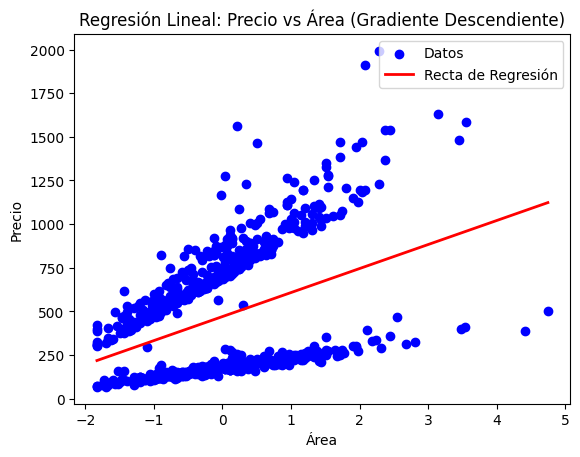


Pseudoinversa:
MSE Train: 105707.49295436605 | MSE Validation: 96292.98006516682


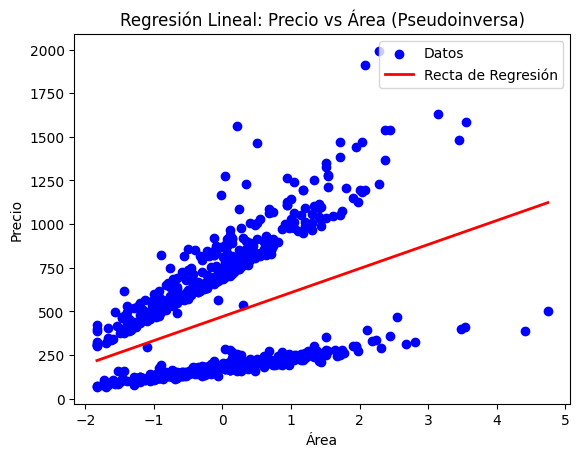

In [57]:
from utils import model_onefeature
model_onefeature(xn_train[["area"]], dy_train, xn_val[["area"]], dy_val)

El modelo que usa solo el **área de la propiedad** tiene un **`MSE alto (96292)`**, algo esperable al trabajar con una única variable.  

Como vimos en el análisis de variables, el **precio por metro cuadrado no es constante**, sino que varía según la ubicación y el tipo de propiedad. Esto provoca que los datos se agrupen en zonas diferenciadas, haciendo que la **recta de regresión** quede en una posición intermedia, sin ajustarse bien a ninguna de ellas.  

Tanto la **`pseudoinversa`** como el **`gradiente descendente`** dan resultados similares, con errores parecidos. La falta de más información hace que el modelo no pueda capturar estas diferencias.  

Ahora entrenaremos un nuevo modelo incluyendo **más características importantes** para ver cuánto mejora la precisión y qué información aportan al resultado. Además, intentaremos **predecir el precio de una vivienda**.  


In [58]:
from utils import metricas
amanda = pd.read_csv("../data/raw/vivienda_Amanda.csv")
convert_areaunits(amanda)
one_hot_encoder(amanda)
amanda = handle_missing_values(amanda)
amanda = (amanda - media) / desv
metricas(xn_train, dy_train, xn_val, dy_val, amanda)




--- Comparación de métodos ---

Gradiente Descendiente:
MSE Train: 15925.52 | MSE Validation: 12819.81
Predicción de price: [795.49139706]

Pseudoinversa:
MSE Train: 15888.87 | MSE Validation: 12826.73
Predicción de price: [796.38750815]


Los resultados muestran una **mejora considerable en la precisión** del modelo al incorporar más características. El **MSE se reduce notablemente**, lo que indica que las predicciones se acercan más a los valores reales de `dy_val`.  

La predicción del `price` es similar en ambos métodos, lo que sugiere que ambos enfoques logran ajustes equivalentes en este caso.  

Esto tiene sentido, ya que al usar solo `area` no se tenía en cuenta que **el valor del metro cuadrado no es el mismo en todas las propiedades**. Por ejemplo, el **área de una casa** no se valora igual que la de un departamento, y lo mismo ocurre entre distintas zonas.  

Al incluir este tipo de variables, el modelo puede capturar mejor estas diferencias y realizar predicciones más precisas.  

In [59]:
df = pd.concat([df_dev, df_test], ignore_index=True)
valor_m2_casa = df.loc[df["is_house"] == 1, "price"] / df.loc[df["is_house"] == 1, "area"]
promedio_valor_m2_casa = valor_m2_casa.mean()
print(f"Valor promedio por m² de una casa: {promedio_valor_m2_casa:.2f}")
valor_m2_casa = df.loc[df["is_house"] == 0, "price"] / df.loc[df["is_house"] == 0, "area"]
promedio_valor_m2_casa = valor_m2_casa.mean()
print(f"Valor promedio por m² de un departamento: {promedio_valor_m2_casa:.2f}")


Valor promedio por m² de una casa: 3.54
Valor promedio por m² de un departamento: 6.00


Para comprender la influencia de cada variable en la predicción del precio, analizaremos los coeficientes obtenidos en la regresión lineal. Estos coeficientes indican cuánto varía el precio ante un cambio unitario en cada característica, permitiéndonos evaluar su influencia relativa.

En esta ocasión, trabajaremos con los datos **sin normalizar**, lo que nos permitirá interpretar los coeficientes en sus unidades originales. Dado que el entrenamiento con **gradiente descendiente** genera problemas de **overflow**, utilizaremos el método de **pseudoinversa** para evitar estos inconvenientes. Esto nos permitirá obtener una representación clara del impacto de cada característica en el precio de las propiedades.

In [60]:
from utils import load_model
model = load_model(dx_train, dy_train, "pinv")
model.mostrar_coeficientes()

Coeficientes del modelo:
bias: -327.1721
area: 4.4790
is_house: 80.7563
has_pool: 52.6922
age: -3.0878
rooms: 20.2487
zona: 631.1481


El análisis de los coeficientes nos permite entender cómo cada característica impacta en el precio de una propiedad. La **ubicación** es el factor con mayor influencia, con una diferencia de precio significativa entre zonas. Le sigue el **tipo de vivienda**, donde las casas suelen ser más caras que los departamentos.  

La presencia de una **pileta** también tiene un efecto positivo en el precio, aunque menor en comparación con otros factores. Asimismo, el **área** y la **cantidad de habitaciones** contribuyen al valor de la propiedad, mientras que la **antigüedad** tiene un impacto negativo, reduciendo el precio a medida que aumenta.  

Al no normalizar los datos, los coeficientes se interpretan directamente en **unidades monetarias**, lo que facilita la evaluación de su impacto real en el precio.

# Feature Engineering  

El *Feature Engineering* permite mejorar la capacidad predictiva del modelo al generar nuevas variables que capturan relaciones relevantes entre los datos. En este caso, se crearon características derivadas a partir de las originales para mejorar la predicción del precio de una propiedad.  

Se incorporaron nuevas variables como la relación entre área y cantidad de habitaciones (`area_per_room`), un indicador de lujo (`luxury`), y una transformación logarítmica del área (`log_area`) para reducir el impacto de valores extremos. También se incluyó la interacción entre el tipo de propiedad y la antigüedad (`is_house_age`), así como la combinación entre la zona y el área total (`zona_area`).  

Las características generadas son las siguientes:  

| **Variable**      | **Descripción** |
|-------------------|----------------|
| ***`area_per_room`*** | Relación entre el área total y el número de habitaciones. |
| ***`luxury`*** | Indicador de lujo basado en si la propiedad es una casa, tiene pileta y la cantidad de habitaciones. |
| ***`log_area`*** | Transformación logarítmica del área para reducir sesgo en la distribución. |
| ***`is_house_age`*** | Producto entre si es casa y la antigüedad, para analizar si las casas más nuevas son más caras. |
| ***`zona_area`*** | Interacción entre la zona y el área total de la propiedad. |

Este conjunto de nuevas características permite capturar información relevante y puede contribuir a mejorar la precisión del modelo de predicción de precios.

In [61]:
from utils import feature_engineering
feature_engineering(dx)
feature_engineering(amanda)
dx_train, dx_val, dy_train, dy_val = train_val_split(dx, dy, 0.8)
xn_train, xn_val, media, desv = normalize(dx_train, dx_val)
metricas(xn_train, dy_train, xn_val, dy_val, amanda)


--- Comparación de métodos ---

Gradiente Descendiente:
MSE Train: 6476.09 | MSE Validation: 3373.03
Predicción de price: [613.37915616]

Pseudoinversa:
MSE Train: 6026.27 | MSE Validation: 3129.12
Predicción de price: [557.34773812]


Los resultados muestran una **mejora significativa** en la precisión del modelo tras aplicar *Feature Engineering*.  

Se observa que tanto en el **`Gradiente Descendiente`** como en la **`Pseudoinversa`**, el **`MSE`** disminuyo considerablemente en comparación con el modelo original. Esto indica que las nuevas características han permitido capturar mejor las relaciones entre las variables, reduciendo el error en la predicción del precio.  

Además, la **`Pseudoinversa` comienza a mostrar un menor error en comparación con el `Gradiente Descendiente`**, especialmente en la validación, donde el **MSE es más bajo**. Esto sugiere que la Pseudoinversa está logrando un mejor ajuste con las nuevas características, mientras que el Gradiente Descendiente aún presenta un error ligeramente mayor. 


Dado el efecto positivo de las nuevas características, exploraremos qué sucede al generar **300 features adicionales**. Evaluaremos cómo impacta en el modelo y su precisión, analizando si el exceso de características mejora o perjudica el rendimiento.

In [62]:
from utils import excessive_feature_engineering
excessive_feature_engineering(dx, xn_train, xn_val, dy_train, dy_val)

MSE train: 341549.8304880525
MSE val: 305494.11204097327


El experimento fue solo posible con pseudoinversa, ya que gradiente descendiente generaba un overflow.

Como era de esperarse, si bien **agregar nuevas características de manera adecuada mejora la precisión del modelo, un exceso de ellas puede ser contraproducente**. En este caso, no solo se observa una pérdida de generalización en validación, sino también un deterioro del rendimiento en entrenamiento. Esto indica que el modelo no solo deja de captar la información relevante, sino que también se vuelve incapaz de ajustarse correctamente a los propios datos de entrenamiento, lo que sugiere **problemas de redundancia y ruido** en las nuevas características generadas.

# Regularización  

En los modelos de regresión lineal, los coeficientes pueden volverse demasiado grandes si las variables están altamente correlacionadas o si hay ruido en los datos, lo que puede llevar a sobreajuste. Para mitigar este problema, se aplican técnicas de **regularización**, que agregan una penalización a los coeficientes del modelo para controlar su magnitud.  

En este caso, se incorporaron términos de **`regularización L1 (Lasso) y L2 (Ridge)`** en la regresión lineal. La regularización **`L2 (Ridge)`** ayuda a reducir la varianza del modelo al penalizar los coeficientes elevados, mientras que **`L1 (Lasso)`** tiende a hacer que algunos coeficientes sean exactamente cero, favoreciendo la selección de variables.  

Para evaluar el impacto de la regularización, entrenamos un modelo con **`L1 y L2`**, utilizando **gradiente descendiente** para ambos y **pseudoinversa** exclusivamente para `L2`. Luego, se analizó cómo varían los coeficientes en función del coeficiente de penalización λ.

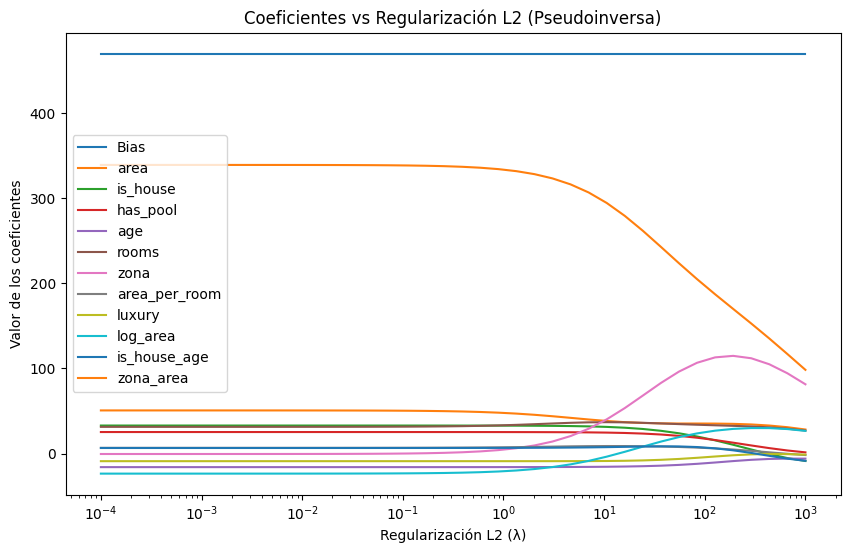

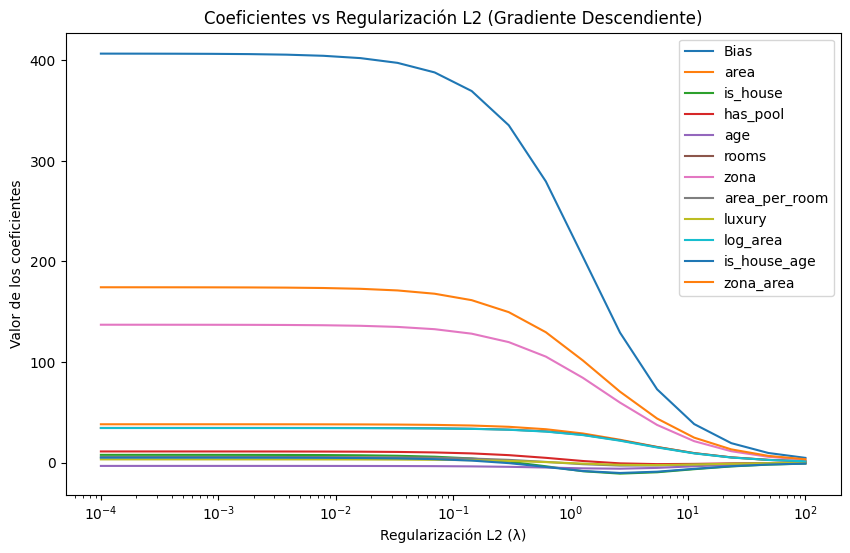

In [63]:
from utils import graficar_coef_vs_l
graficar_coef_vs_l(xn_train, dy_train, "L2")

- En **`pseudoinversa`**, para valores pequeños de λ los coeficientes se mantienen estables. A medida que λ aumenta, los coeficientes decrecen, pero algunos muestran un comportamiento no monótono. Para ver bien este efecto, se aumentó el valor máximo de λ hasta 10³.  
- En **`gradiente descendente`**, los coeficientes se reducen de manera más progresiva y uniforme. Sin embargo, para evitar que los coeficientes se disparen a valores extremos, fue necesario reducir el learning rate de 0.01 a 0.001.  

Para λ pequeños, ambos métodos muestran coeficientes similares. Para valores grandes, gradiente descendente lleva los coeficientes más rápidamente a cero, mientras que pseudoinversa muestra transiciones más bruscas. La elección del método afecta la forma en que los coeficientes se ajustan, aunque en ambos casos la regularización L2 logra reducir su magnitud para mitigar el sobreajuste.  

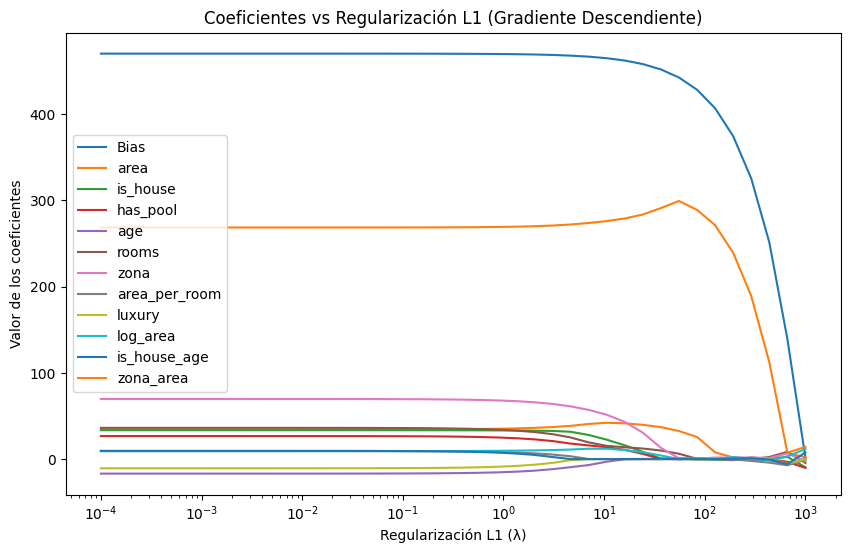

In [64]:
graficar_coef_vs_l(xn_train, dy_train, "L1")

Un aspecto notable es que los coeficientes no se reducen a cero simultáneamente, como ocurría en L2. En su lugar, algunos desaparecen rápidamente, mientras que otros tardan más en anularse. Esto sucede porque `L1` tiende a favorecer soluciones donde solo unas pocas características tienen coeficientes distintos de cero, eliminando primero aquellas con menor impacto en la predicción y preservando por más tiempo las más relevantes.  

En este caso, las variables `area`, `zona` y la variable derivada de ambas (`zona_area`) son las que más tardan en desaparecer, lo que sugiere que tienen un mayor peso en la predicción.  

En general, la regularización no solo reduce la magnitud de los coeficientes, sino que también selecciona características por orden de relevancia al hacer que algunos desaparezcan por completo en diferentes momentos.

Dado lo observado en los gráficos de `L2`, probaremos con valores de lambda **0.1 y 1**, ya que estos permiten evaluar el impacto de la regularización en la selección de características sin reducir demasiado los coeficientes relevantes.

In [65]:
print("λ = 0.1: ")
metricas(xn_train, dy_train, xn_val, dy_val, amanda, L1=0, L2=0.1)
print("\nλ = 1: ")
metricas(xn_train, dy_train, xn_val, dy_val, amanda, L1=0, L2=1)

λ = 0.1: 

--- Comparación de métodos ---

Gradiente Descendiente:
MSE Train: 9522.30 | MSE Validation: 5236.31
Predicción de price: [605.4295233]

Pseudoinversa:
MSE Train: 6026.30 | MSE Validation: 3127.03
Predicción de price: [557.85092292]

λ = 1: 

--- Comparación de métodos ---

Gradiente Descendiente:
MSE Train: 77400.01 | MSE Validation: 64860.07
Predicción de price: [393.17583231]

Pseudoinversa:
MSE Train: 6028.98 | MSE Validation: 3111.03
Predicción de price: [562.10395153]


Los resultados muestran que la **Pseudoinversa** no experimentó un cambio significativo en su error, manteniéndose en valores similares a los obtenidos sin regularización. En cambio, **Gradiente Descendiente** sufrió un aumento considerable en su error, lo que indica que la elección de λ impactó fuertemente su desempeño.  

En teoría, la regularización `L2` beneficia a la regresión al reducir la varianza del modelo y estabilizar los coeficientes, evitando valores extremos y controlando el sobreajuste. Sin embargo, en este caso, **no se observó una mejora en el desempeño**. La Pseudoinversa se mantuvo prácticamente igual, mientras que Gradiente Descendiente experimentó un deterioro en su error. Esto sugiere que la elección de λ no fue óptima o que el problema en cuestión no se benefició de la regularización `L2` en estos modelos.  

Para comprender mejor este efecto, realizaremos un barrido del hiperparámetro λ, evaluando su impacto en el error cuadrático medio (ECM) sobre el conjunto de validación. Esto nos permitirá analizar cómo varía el desempeño del modelo en función de la regularización y determinar si existe un valor óptimo de λ para este caso.  

In [66]:
import numpy as np
lambdas = np.logspace(-1, 1, 6)
for lamb in lambdas:
    metricas(xn_train, dy_train, xn_val, dy_val, amanda, L1=0, L2=lamb)
    print("\n Valor de λ = ", lamb)


--- Comparación de métodos ---

Gradiente Descendiente:
MSE Train: 9522.30 | MSE Validation: 5236.31
Predicción de price: [605.4295233]

Pseudoinversa:
MSE Train: 6026.30 | MSE Validation: 3127.03
Predicción de price: [557.85092292]

 Valor de λ =  0.1

--- Comparación de métodos ---

Gradiente Descendiente:
MSE Train: 18707.97 | MSE Validation: 12671.57
Predicción de price: [563.11051353]

Pseudoinversa:
MSE Train: 6026.45 | MSE Validation: 3123.99
Predicción de price: [558.59901231]

 Valor de λ =  0.251188643150958

--- Comparación de métodos ---

Gradiente Descendiente:
MSE Train: 49026.03 | MSE Validation: 39293.04
Predicción de price: [462.77181621]

Pseudoinversa:
MSE Train: 6027.38 | MSE Validation: 3117.00
Predicción de price: [560.41575894]

 Valor de λ =  0.6309573444801934

--- Comparación de métodos ---

Gradiente Descendiente:
MSE Train: 114292.14 | MSE Validation: 98339.19
Predicción de price: [318.32490207]

Pseudoinversa:
MSE Train: 6032.81 | MSE Validation: 3103.09
P

Se observa que la regularización **`L2`** impacta de manera diferente en cada método.  

- En el caso de la **Pseudoinversa**, los resultados se mantienen **estables** a lo largo de los distintos valores de `λ`, con variaciones mínimas en los errores y predicciones. Esto indica que la regularización **no afecta significativamente** el ajuste del modelo en este caso.  
- En **Gradiente Descendiente**, en cambio, la inclusión de regularización **`L2`** genera un **incremento progresivo en los errores**, tanto en el conjunto de entrenamiento como en el de validación. A medida que `λ` aumenta, los coeficientes se ven más restringidos, lo que lleva a una **pérdida de información relevante** y un **deterioro** en la capacidad predictiva del modelo.  

En teoría, la regularización **`L2`** impone restricciones en la magnitud de los coeficientes para evitar el sobreajuste. Sin embargo, en este caso, **no se observó un beneficio en Gradiente Descendiente**, sino un **empeoramiento del error**.  

Dado que **Gradiente Descendiente** fue el método que más reaccionó a la regularización en comparación con la **Pseudoinversa**, realizaremos una **validación cruzada** específicamente para este método. Esto nos permitirá analizar con mayor precisión cómo varía el **error cuadrático medio (ECM)** en función de `λ` y determinar si existe un valor óptimo para la regularización.

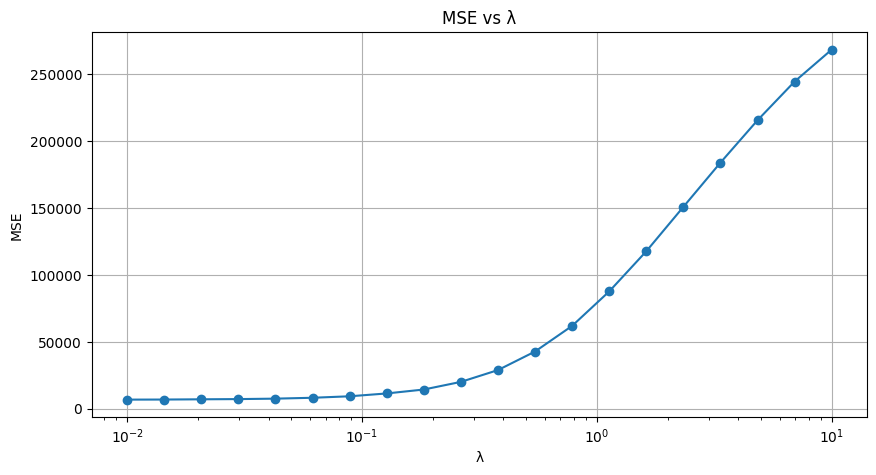

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from data_splitting import cross_val
lambdas = np.logspace(-2, 1, 20)
mses = []
for lamb in lambdas:
    mse = cross_val(xn_train, dy_train, l2=lamb)
    mses.append(mse)
plt.figure(figsize=(10, 5))
plt.plot(lambdas, mses, marker="o")
plt.xscale("log")
plt.xlabel("λ")
plt.ylabel("MSE")
plt.title("MSE vs λ")
plt.grid()
plt.show()

El **error cuadrático medio (MSE)** se mantiene estable para valores pequeños de `λ`. Sin embargo, a partir de **`λ ≈ 0.1`**, el error comienza a **crecer bruscamente**, reflejando una **pérdida de capacidad predictiva**.  

Este comportamiento sugiere que la regularización **`L2`** introduce una penalización excesiva en los coeficientes, reduciendo su magnitud hasta el punto de afectar el rendimiento del modelo. A diferencia de la **Pseudoinversa**, donde el impacto de `λ` es prácticamente nulo, en **Gradiente Descendiente** el efecto es mucho más pronunciado, llevando a un **deterioro notable** en la precisión.  

Así, la regularización en este contexto no actúa como un mecanismo de mejora, sino que compromete el ajuste del modelo, haciéndolo menos eficiente para capturar patrones en los datos.

# Resultados

Con un dataset de **900 muestras** y solo **5 características originales**, la posibilidad de **overfitting es baja**, ya que los modelos no cuentan con suficiente complejidad para sobreajustarse a los datos. En este contexto, la regularización **no aportó mejoras significativas** y, en valores altos de `λ`, incluso resultó perjudicial al restringir demasiado los coeficientes.  

El **feature engineering** jugó un papel clave al proporcionar información más representativa a los modelos, lo que permitió mejorar su capacidad predictiva. Por esta razón, los modelos entrenados con las características expandidas lograron mejores resultados que aquellos que solo utilizaron las variables originales.  

En cuanto al método de ajuste, el enfoque iterativo presentó **mayores dificultades prácticas**, además de mostrar un **ligero incremento en el error** en comparación con la **Pseudoinversa**. Dado que este último método es más estable y eficiente computacionalmente, y que la regularización no alteró su desempeño, la mejor opción es un modelo basado en **`Pseudoinversa con feature engineering`**, sin importar si se aplica o no regularización.  

---

Para evaluar la capacidad predictiva del modelo seleccionado, computamos y reportamos el **`MAE (Mean Absolute Error)`** y el **`RMSE (Root Mean Squared Error)`** sobre el conjunto de prueba.

In [68]:
from utils import load_model
from metrics import rmse, mae, mse
model = load_model(xn_train, dy_train, "pinv")
dx_test = df_test.drop(columns=["price"])
dy_test = df_test["price"]
feature_engineering(dx_test)
xn_test = (dx_test - media) / desv
print(f"RMSE: {rmse(xn_test, dy_test, model.obtener_coeficientes()):.2f}")
print(f"MAE: {mae(xn_test, dy_test, model.obtener_coeficientes()):.2f}")

RMSE: 81.54
MAE: 52.00


El **RMSE** y el **MAE** obtenidos permiten evaluar el rendimiento del modelo en términos de error de predicción.  

El **`MAE (Mean Absolute Error)`** indica que, en promedio, las predicciones presentan un error absoluto de **52 unidades**, lo que refleja la desviación media entre las estimaciones y los valores reales. Por otro lado, el **`RMSE (Root Mean Squared Error)`** es de **81.50**, lo que sugiere que existen algunos errores más grandes que elevan la variabilidad del modelo, dado que esta métrica penaliza más los errores grandes.  

Estos valores confirman que el modelo logra un **balance adecuado entre precisión y estabilidad**, sin evidencias de sobreajuste. La elección de **`Pseudoinversa con feature engineering`** demostró ser efectiva, validando la importancia de trabajar con una representación enriquecida de los datos en lugar de depender exclusivamente de la regularización.